# Assignment 1 - Ridge and LASSO Regression

In this assignment we'll look at the affect of using regularization on linear regression models that we train. You will write code to train models that use different regularizers and different penalties to analyze how this affects the model.


Fill in the cells provided marked `TODO` with code to answer the questions. Answers should do the computation stated rather than writing in hard-coded values. So for example, if a problem asks you to compute the average age of people in a dataset, you should be writing Python code in this notebook to do the computation instead of plugging it into some calculator and saving the hard-coded answer in the variable. In other words, we should be able to run your code on a smaller/larger dataset and get correct answers for those datasets with your code.

Note, you are not allowed to share any portions of this notebook outside of this class.

> Copyright ©2023 Emily Fox and Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2024 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [1]:
# Conventionally people rename these common imports for brevity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Magic command to make the plots appear in-line (it's actually called a "magic command")
%matplotlib inline

**NOTE**: Be sure to run every cell in the notebook! The `###SKIP` is for the autograder. 

In [2]:
### SKIP
sales = pd.read_csv('home_data.csv')

# Set seed for the whole program
np.random.seed(416)

Do not modify the below cell. It configures the autograder, which will award 0 points if it doesn't run.

In [3]:
### edTest(test_load_data) ###

For this assignment, we will only be using a very small subset of the data to do our analysis. This is not something you would usually do in practice, but is something we do for this assignment to simplify the complexity of this dataset. The data is pretty noisy and to get meaningful results to demonstrate the theoretical behavior, you would need to use a much more complicated set of features that would be a bit more tedious to work with.

**NOTE**: Do NOT change `random_state=0`, else the autograder will fail.

In [4]:
# Selects 1% of the data
# NOTE: Do not change the random_state=0, else the autograder will fail
sales = sales.sample(frac=0.01, random_state=0) 

print(f'Number of points: {len(sales)}')
sales.head()

Number of points: 216


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,...,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,...,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,...,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,...,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,...,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261


## Q1 - Feature Engineering
First, we do a bit of feature engineering by creating features that represent the squares of each feature and the square root of each feature. One benefit of using regularization is you can include more features than necessary and you don't have to be as worried about overfitting since the model is regularized.

In the following cell, complete the code inside the loop to compute the square of each feature the the square root of each feature. *Note*: While we did mention there are some helpful classes in scikit-learn for computing polynomial features, for this assignment we are just computing the square and the square root so we recommend writing the code in pandas yourself.

In [5]:
### edTest(test_feature_extraction) ###

from math import sqrt

# All of the features of interest
selected_inputs = [
    'bedrooms', 
    'bathrooms',
    'sqft_living', 
    'sqft_lot', 
    'floors', 
    'waterfront', 
    'view', 
    'condition', 
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built', 
    'yr_renovated'
]

# Compute the square and sqrt of each feature
# At the end of the for loop: 
#    - sales should have additional columns for the square and 
#      sqrt of each of the selected inputs.
#    - all_features should contain the names (as strings) of all 
#      the features we care about.
all_features = []
for feature_name in selected_inputs:
    
    squared_feature_name = feature_name + '_square'
    sqrt_feature_name = feature_name + '_sqrt'
    
    # TODO compute the square of the column feature_name, add it to sales as a 
    # new column, squared_feature_name
    sales[squared_feature_name] = sales[feature_name] ** 2
    
    # TODO compute the sqrt of the column feature_name, add it to sales as a
    # new column, sqrt_feature_name
    sales[sqrt_feature_name] = sales[feature_name] ** (1/2)

    # Add the feature names to all_features
    all_features.extend([feature_name, squared_feature_name, sqrt_feature_name])
    
# Split the data into features and price
price = sales['price']
sales = sales[all_features]

sales.head()

,bedrooms,bedrooms_square,bedrooms_sqrt,bathrooms,bathrooms_square,bathrooms_sqrt,sqft_living,sqft_living_square,sqft_living_sqrt,sqft_lot,...,sqft_above_sqrt,sqft_basement,sqft_basement_square,sqft_basement_sqrt,yr_built,yr_built_square,yr_built_sqrt,yr_renovated,yr_renovated_square,yr_renovated_sqrt
17384,2,4,1.414214,1.50,2.2500,1.224745,1430,2044900,37.815341,1650,...,37.815341,0,0,0.000000,1999,3996001,44.710178,0,0,0.0
722,4,16,2.000000,3.25,10.5625,1.802776,4670,21808900,68.337398,51836,...,68.337398,0,0,0.000000,1988,3952144,44.586994,0,0,0.0
2680,2,4,1.414214,0.75,0.5625,0.866025,1440,2073600,37.947332,3700,...,34.641016,240,57600,15.491933,1914,3663396,43.749286,0,0,0.0
18754,2,4,1.414214,1.00,1.0000,1.000000,1130,1276900,33.615473,2640,...,33.615473,0,0,0.000000,1927,3713329,43.897608,0,0,0.0
14554,4,16,2.000000,2.50,6.2500,1.581139,3180,10112400,56.391489,9603,...,56.391489,0,0,0.000000,2002,4008004,44.743715,0,0,0.0


## Split Data
Next, we need to split our data into our train, validation, and test data. To do this, we will use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split up the dataset. For this assignment we will use 70% of the data to train, 10% for validation, and 20% to test. 

**NOTE**: Do NOT change `random_state=6`, else the autograder will fail.

In [6]:
from sklearn.model_selection import train_test_split

# NOTE: Do not change the random_state=6, else the autograder will fail
sales_train_and_validation, sales_test, price_train_and_validation, price_test = \
    train_test_split(sales, price, test_size=0.2, random_state=6)
sales_train, sales_validation, price_train, price_validation = \
    train_test_split(sales_train_and_validation, price_train_and_validation, test_size=.125, random_state=6) # .10 (validation) of .80 (train + validation)

## Q2 - Standardization

We first need to do a little bit more pre-processing to prepare the data for model training. Models like Ridge and LASSO assume the input features are standardized (mean 0, std. dev. 1) and the target values are centered (mean 0). If we do not do this, we might get some unpredictable results since we violate the assumption of the models!

So in the next cell, you should standardize the data in train, validation, and test using the following instructions:
* Use the [StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) preprocessor provided by scikit-learn to do the standardization for you. 
  * Note that you first `fit` it to the data so it can compute the mean/standard deviation and then `transform` to actually change the data. You'll find the examples on this documentation very helpful.
* You should only do this transformation on the features we are using of the data (not any of the other data inputs or the target values). 
* This next note will sound a bit weird, but it's an important step. **You should only do the standardization calculation (e.g., the mean and the standard deviation) on the *training* set and use those statistics to scale the validation and test set**. In other words, the validation and test set should be standardized using the statistics from the training data so that you are using a consistent transformation throughout. This is important to do since you need to apply the same transformation process to every step of the data and you shouldn't use statistics from data outside of your training set in your transformations.

In [7]:
### edTest(test_standardization) ###

from sklearn.preprocessing import StandardScaler

# TODO preprocess the training, validation, and test data
scaler = StandardScaler()
scaler.fit(sales_train)

sales_train_standardized = scaler.transform(sales_train)
sales_validation_standardized = scaler.transform(sales_validation)
sales_test_standardized = scaler.transform(sales_test)

# Linear Regression 
## Q3) Linear Regression Baseline

As a baseline, we will first, train a regular `LinearRegression` model on the data using the features in `all_features` and report its **test RMSE**. Write the code in the cell below to calculate the answer. Save your result in a variable named `test_rmse_unregularized`.


In [8]:
### edTest(test_train_linear_regression) ###

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# TODO Train a linear regression model
linear = LinearRegression()

linear.fit(sales_train_standardized, price_train)

rmse_test_unregularized = mean_squared_error(linear.predict(sales_test_standardized), price_test, squared=False)
print("Test RMSE", rmse_test_unregularized)

Test RMSE 384955.7993667478


c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


--- 
# Ridge Regression
At this point, you might be looking forward at the homework and seeing how long it is! We want to provide a lot of instruction so you aren't left completely in the dark on what to do, but we are also trying to avoid just giving you a bunch of starter code and just having you fill in the blanks. This section is very long because it tries to give really detailed instructions on what to compute. The next section on LASSO has almost exactly the same steps so it will be a lot easier doing that part of the assignment!

In this section, we will do some **hyper-parameter tuning** to find the optimal setting of the regularization constant $\lambda$ for Ridge Regression. Remember that $\lambda$ is the coefficient that controls how much the model is penalized for having large weights in the optimization function.

$$\hat{w}_{ridge} = \min_w MSE(w) + \lambda \left\lVert w \right\rVert_2^2$$

where $\left\lVert w \right\rVert_2^2 = \sum_{j=1}^D w_j^2$ is the $l_2$-norm of the parameters. By default, `sklearn`'s `Ridge` class does not regularize the intercept.

## Q4) Train Ridge Models
For this part of the assignment, you will be writing code to find the optimal setting of the penalty $\lambda$. Below, we describe what steps you will want to have in your code to compute these values:

*Implementation Details*
* Use the following choices of $l_2$ penalty: $[10^{-5}, 10^{-4}, ..., 10^4, 10^5]$. In Python, you can create a list of these numbers using `np.logspace(-5, 5, 11, base=10)`. 
* Use the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class from sklearn to train a Ridge Regression model on the **training** data. The **only** arguments you need to pass when constructing the Ridge model are $\lambda$, which lets you specify what you want the $l_2$ penalty to be. (NOTE: sklearn's Ridge class uses `alpha` instead of `lambda`; only the name is different but they function in the same way.)
* Evaluate both the training error and the validation error for the model by reporting the **RMSE** of each dataset.
* **Put all of your results in a pandas `DataFrame` named `ridge_data`** so you can analyze them later. The `ridge_data` should have a row for each $l_2$ penalty you tried and should have the following columns:
  * `l2_penalty`: The $l_2$ penalty for that row
  * `model`: The actual `Ridge` model object that was trained with that $l_2$ penalty
  * `rmse_train`: The training RMSE for that model
  * `rmse_validation`: The validation RMSE for that model
* To build up this `DataFrame`, we recommend first building up a list of dictionary objects and then converting that to a `DataFrame`. For example, the following code would produce the following `pandas.DataFrame`.

  ```python
  data = []
  for i in range(3):
      data.append({
          'col_a': i,
          'col_b': 2 * i
      }
  data_frame = pd.DataFrame(data)
  ```

  | col_a | col_b | 
  |-------|-------|
  |   0   |   0   | 
  |   1   |   2   | 
  |   2   |   4   |

*Hints: Here is a development strategy that you might find helpful*
* You will need a loop to loop over the possible $l_2$ penalties. Try writing the code without a loop first with just one setting of $\lambda$. Try writing a lot of the code without a loop first if you're stuck to help you figure out how the pieces go together. You can safely ignore building up the result `DataFrame` at first, just print all the information out to start! 
* If you are running into troubles writing your loop, try to print values out to investigate what's going wrong.
* Remember to use RMSE for calculating the error!


In [9]:
### edTest(test_ridge) ###

from sklearn.linear_model import Ridge

l2_lambdas = np.logspace(-5, 5, 11, base = 10)

# TODO Implement code to evaluate Ridge Regression with various l2 Penalties
# Note that Ridge uses "alpha" to refer to the variable we have been calling "lambda"

data = []
for i in range(len(l2_lambdas)):
    ridge_model = Ridge(alpha=l2_lambdas[i])
    ridge_model.fit(sales_train_standardized, price_train)

    data.append({
        'l2_penalty': l2_lambdas[i],
        'model': ridge_model,
        'rmse_train': mean_squared_error(ridge_model.predict(sales_train_standardized), price_train, squared=False),
        'rmse_validation': mean_squared_error(ridge_model.predict(sales_validation_standardized), price_validation, squared=False)
    })
ridge_data = pd.DataFrame(data)

ridge_data

c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarnin

,l2_penalty,model,rmse_train,rmse_validation
0,0.00001,Ridge(alpha=1e-05),146188.566942,392112.522240
1,0.00010,Ridge(alpha=0.0001),146210.884175,392721.061566
2,0.00100,Ridge(alpha=0.001),146610.292053,393099.892724
3,0.01000,Ridge(alpha=0.01),147967.692703,369263.393012
4,0.10000,Ridge(alpha=0.1),151619.819399,330722.661247
5,1.00000,Ridge(),154932.690092,302623.478585
6,10.00000,Ridge(alpha=10.0),161876.430362,282876.469131
7,100.00000,Ridge(alpha=100.0),181371.431142,283001.128683
8,1000.00000,Ridge(alpha=1000.0),244296.061524,341022.423065
9,10000.00000,Ridge(alpha=10000.0),328840.881425,486101.010743


Next, let's investigate how the penalty affects the train and validation error by running the following plotting code. 

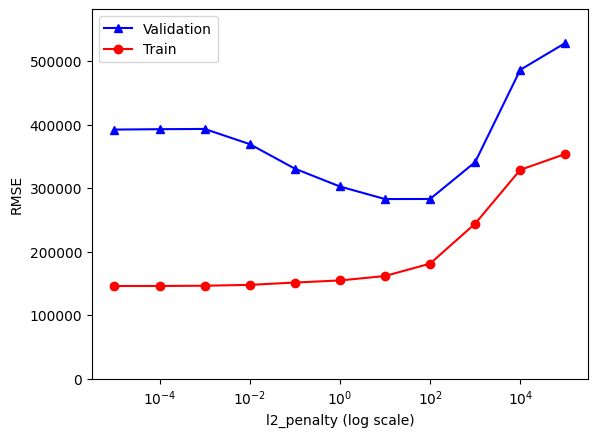

In [10]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['rmse_validation'], 
         'b-^', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['rmse_train'], 
         'r-o', label='Train')

# Set y-limits
rmse_max = max(ridge_data['rmse_train'].max(), ridge_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

Next, we want to actually look at which model we think will perform best. First we define a helper function that will be used to inspect the model parameters.

In [11]:
def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(features, model.coef_))
    print(*feats, sep = "\n")

## Q5 - Inspecting Coefficients
In the cell below, write code that uses the `ridge_data` `DataFrame` to select which L2 penalty we would choose based on the evaluations we did in the previous section. Do not hard-code the best model parameters, write code to find them from the DataFrame you computed. Compute the following: 

* **Q5.1** -  The best L2 penalty based on the model evaluations. Save this L2 penalty in a variable called `best_l2`.
* **Q5.2** - The best model's error on the **test** dataset. Report the number as an RMSE stored in a variable called `rmse_test_ridge`.
* **Q5.3** The number of coefficients in the best model that are 0. Save this in a variable called `num_zero_coeffs_ridge`. Use the `print_coefficients` function to help you check your result.

Recall that you **may NOT hardcode** values and must instead write code to compute the values; we are testing the data on a slightly different dataset, so hardcoded values from this dataset will be marked as wrong.

Use the next cell answer all three questions. You should also print out the values so you can inspect them.

### Tip

A `pandas` `DataFrame` has a method `idxmin()` function to find the index of the smallest value in a column, and a property `loc` to access a sepcified index. As an example, suppose we had a `DataFrame` named `df`:

| a | b | c |
|---|---|---|
| 1 | 2 | 3 |
| 2 | 1 | 3 |
| 3 | 2 | 1 |

If we wrote the code 
```python
index = df['b'].idxmin()
row = df.loc[index]
```

It would first find the index of the smallest value in the `b` column and then uses the `.loc` property of the `DataFrame` to access that particular row. It will return a `Series` object (basically a Python dictionary) which means you can use syntax like `row['a']` to access a particular column of that row.

In [12]:
### edTest(test_ridge_analysis) ###

# TODO Print information about best l2 model
bestseries = ridge_data.loc[ridge_data["rmse_validation"].idxmin()]
best_l2 = bestseries["l2_penalty"]
rmse_test_ridge = mean_squared_error(bestseries["model"].predict(sales_test_standardized), price_test, squared=False)

numzeroes = 0
# for i in range(len(list(zip(selected_inputs, bestseries["model"].coef_)))):
#   if (list(zip(selected_inputs, bestseries["model"].coef_))[i] == 0):
#     numzeroes += 1
num_zero_coeffs_ridge = sum(coef == 0 for coef in bestseries["model"].coef_)
# note to self: come back to this. why did doing bestseries["model"] not work at first???

# print_coefficients(selected_inputs, bestseries['model'])

# Print your results to help you check their correctness.
print('L2 Penalty',  best_l2)
print('Test RSME', rmse_test_ridge)
print('Num Zero Coeffs', num_zero_coeffs_ridge)

L2 Penalty 10.0
Test RSME 354624.8472519469
Num Zero Coeffs 0


c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


--- 
# LASSO Regression
In this section you will do basically the exact same analysis you did with Ridge Regression, but using LASSO Regression instead. It's okay if your code for this section looks very similar to your code for the last section. 

Remember that for LASSO we choose the parameters that minimize this quality metric instead 

$$\hat{w}_{LASSO} = \min_w MSE(w) + \lambda \left\lVert w \right\rVert_1$$

where $\left\lVert w \right\rVert_1 = \sum_{j=1}^D | w_j |$ is the L1 norm of the parameter vector.

## Q6) Train LASSO Models
We will use the same set of instructions for LASSO as we did for Ridge, except for the following differences. Please refer back to the Ridge Regression instructions and your code to see how these differences fit in!

* Use the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) model. Like before, the only parameters you need to pass in are $\lambda$ for the L1 penalty. Like before, sklearn uses the parameter `alpha` instead of `lambda`, but it does the same thing as the `lambda` we discussed in class.
* The range L1 penalties should be $[10, 10^2, ..., 10^7]$. In Python, this is `np.logspace(1, 7, 7, base=10)`.
* The result should be stored in a `DataFrame` named `lasso_data`. All the columns should have the same name and corresponding values except the penalty column should be called `l1_penalty`.
* It is okay if your code prints some `ConvergenceWarning` warnings, these should not impact your results!.

You do not need to worry about your code being redundant with the last section for this part.

In [13]:
### edTest(test_lasso) ###

from sklearn.linear_model import Lasso

l1_lambdas = np.logspace(1, 7, 7, base=10)

# TODO Implement code to evaluate LASSO Regression with various L1 penalties
data = []
for i in range(len(l1_lambdas)):
    lasso_model = Lasso(alpha=l1_lambdas[i])
    lasso_model.fit(sales_train_standardized, price_train)

    data.append({
        'l1_penalty': l1_lambdas[i],
        'model': lasso_model,
        'rmse_train': mean_squared_error(lasso_model.predict(sales_train_standardized), price_train, squared=False),
        'rmse_validation': mean_squared_error(lasso_model.predict(sales_validation_standardized), price_validation, squared=False)
    })
lasso_data = pd.DataFrame(data)

lasso_data

c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+12, tolerance: 1.913e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\achar\AppData\Local\Pro

,l1_penalty,model,rmse_train,rmse_validation
0,10.0,Lasso(alpha=10.0),151336.667973,335371.150569
1,100.0,Lasso(alpha=100.0),152164.419039,323670.679137
2,1000.0,Lasso(alpha=1000.0),156360.395434,285201.302593
3,10000.0,Lasso(alpha=10000.0),169912.542560,271138.560249
4,100000.0,Lasso(alpha=100000.0),239553.336550,340385.511537
5,1000000.0,Lasso(alpha=1000000.0),357105.698956,533861.713077
6,10000000.0,Lasso(alpha=10000000.0),357105.698956,533861.713077


Like before, let's look at how the L1 penalty affects the performance.

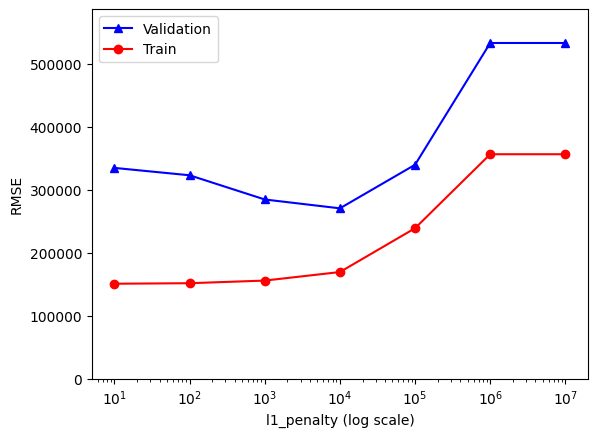

In [14]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_validation'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_train'],
         'r-o', label='Train')

# Set y-limits
rmse_max = max(lasso_data['rmse_train'].max(), lasso_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

## Q7 - Inspecting Coefficients
Like before, in the cell below, write code that uses the `lasso_data` `DataFrame` to select which L1 penalty we would choose based on the evaluations we did in the previous section. Do not hard-code the best model paramteres, write code to find the best model from the values you compute from the DataFrame. Compute the following:

* **Q7.1** -  The best L1 penalty based on the model evaluations. Save this L1 penalty in a variable called `best_l1`.
* **Q7.2** - The best model's error on the **test** dataset. Report the number as an RMSE stored in a variable called `rmse_test_lasso`.
* **Q7.3** - The number of coefficients in the best model that are 0. Store this in a variable called `num_zero_coeffs_lasso`. Note that `-0.0` and `0.0` are the same for our purposes. Use the `print_coefficients` function to help you check your result.

In [15]:
### edTest(test_lasso_analysis) ###

bestseriesl1 = lasso_data.loc[lasso_data["rmse_validation"].idxmin()]
best_l1 = bestseriesl1["l1_penalty"]
rmse_test_lasso = mean_squared_error(bestseriesl1["model"].predict(sales_test_standardized), price_test, squared=False)

numzeroes = 0
# for i in range(len(list(zip(selected_inputs, bestseries["model"].coef_)))):
#   if (list(zip(selected_inputs, bestseries["model"].coef_))[i] == 0):
#     numzeroes += 1
num_zero_coeffs_lasso = sum(coef == 0 for coef in bestseriesl1["model"].coef_)
# note to self: come back to this. why did doing bestseries["model"] not work at first???

# print_coefficients(selected_inputs, bestseries['model'])

# Print your results to help you check their correctness.
print('Best L1 Penalty', best_l1)
print('Test RMSE', rmse_test_lasso)
print('Num Zero Coeffs', num_zero_coeffs_lasso)

Best L1 Penalty 10000.0
Test RMSE 344434.8333379942
Num Zero Coeffs 29


c:\Users\achar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Q7.4 -** Let's look at which coefficients ended up having a 0 coefficient. In the cell below, we print the name of all features with coefficient 0. Note, we actually have to check if it is near 0 since numeric computations in Python sometimes yield slight rounding errors (e.g., how 1/3 is .333333333333 and that can't be represented precisely in a computer)


In [16]:
### edTest(test_best_model_lasso) ###

# TODO: Use code like from the above cell to get the best model.
best_model_lasso = bestseriesl1['model']

zero_coef_features = []
nonzero_coef_features = []
for feature, coef in zip(all_features, best_model_lasso.coef_):
  if abs(coef) <= 10 ** -17:
    zero_coef_features.append(feature)
  else:
    nonzero_coef_features.append(feature)

print("Features with coefficient == 0:", zero_coef_features)
print("Features with coefficient != 0:", nonzero_coef_features)

Features with coefficient == 0: ['bedrooms', 'bedrooms_square', 'bathrooms', 'bathrooms_sqrt', 'sqft_living', 'sqft_living_square', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront_square', 'waterfront_sqrt', 'view', 'view_square', 'view_sqrt', 'condition', 'condition_square', 'condition_sqrt', 'grade', 'grade_sqrt', 'sqft_above', 'sqft_above_sqrt', 'sqft_basement', 'sqft_basement_square', 'sqft_basement_sqrt', 'yr_built_square', 'yr_renovated', 'yr_renovated_sqrt']
Features with coefficient != 0: ['bedrooms_sqrt', 'bathrooms_square', 'sqft_lot_square', 'floors_sqrt', 'waterfront', 'grade_square', 'sqft_above_square', 'yr_built', 'yr_built_sqrt', 'yr_renovated_square']
